In [1]:
import numpy as np
import pandas as pd

from datetime import date
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import gc # сборщик мусора

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

In [3]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [8]:
from pathlib import Path
import os


DATA_ROOT = Path('./data/')
MODELS_PATH = Path('./models/')

# input
DATASET_TRAIN = DATA_ROOT / 'data_train.csv'
DATASET_TEST = DATA_ROOT / 'data_test.csv'
DATASET_FEATURES = DATA_ROOT / 'features.csv'

TRAIN_PART_PATH = DATA_ROOT / 'training_train_part.csv'
TEST_PART_PATH = DATA_ROOT / 'training_test_part.csv'

TRAIN_MERGE = DATA_ROOT / 'train_merge.csv'
TEST_MERGE = DATA_ROOT / 'test_merge.csv'
# output
DATASET_SHORT_FEATURES = DATA_ROOT / 'short_features.csv'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

In [9]:
df_train = pd.read_csv(DATASET_TRAIN).drop(['Unnamed: 0'], axis=1)
df_test = pd.read_csv(DATASET_TEST).drop(['Unnamed: 0'], axis=1)

#### создадим df_features, после создания закоментим код для удобства

In [10]:
# df_big = pd.read_csv(DATASET_FEATURES, chunksize=100000, iterator=True, sep='\t')
# df_list = []
# all_users = pd.concat([df_train, df_test]).id.unique()
# for dfb in df_big:
#     merge = dfb['id'].isin(all_users)
#     dfb_filter = dfb[merge]
#     df_list.append(dfb_filter)
# df_features = df_list[0]
# for number in range(1, len(df_list)):
#     df_features = pd.concat([df_features, df_list[number]], axis=0)

In [11]:
# df_features.to_csv(DATASET_SHORT_FEATURES)

**target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.

**buy_time** - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.

**id** - идентификатор абонента

**vas_id** - подключаемая услуга

**Задача состоит из 2-х подзадач:**
1. Предсказание вероятности подключения услуги
2. Формирование индивидуальных предложений и максимизация выручки

In [12]:
df_short = pd.read_csv(DATASET_SHORT_FEATURES).drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)
df_short.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
1,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,2070757,1540760400,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
3,2071522,1544994000,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4,2075318,1533502800,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,782.383903,...,-501.373846,-242.770792,-25.996269,-37.630448,-167.747724,-14.832889,2.305572,-4.175933,-0.45614,0.0


In [13]:
df_short.describe()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
count,9.023890e+05,9.023890e+05,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,...,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000,902389.000000
mean,2.181789e+06,1.539593e+09,0.045011,0.083067,-0.097768,0.054796,-0.168957,-0.037743,0.020268,0.094469,...,2.253638,1.475141,0.194557,0.012863,-1.705147,-0.073602,-0.024798,0.055467,-0.000681,0.257663
std,1.258521e+06,5.319642e+06,291.888648,482.726654,298.669329,546.362530,310.806921,602.972486,243.849124,381.755492,...,3210.895385,2244.960994,1323.028568,299.558020,1296.239554,260.509355,8.620514,199.718875,11.302048,2.071481
min,2.000000e+00,1.531084e+09,-1151.889971,-1594.119112,-2651.840786,-1634.436798,-2657.258246,-1655.541790,-541.506180,-802.356097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
25%,1.092406e+06,1.534712e+09,-96.799971,-209.479112,-110.740786,-243.156798,-116.158246,-260.451790,-16.086180,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-305.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
50%,2.179373e+06,1.539551e+09,-84.969971,-60.729112,-85.320786,-79.426798,-87.868246,-93.771790,-16.086180,-65.076097,...,-959.373846,-613.770792,-25.996269,-37.630448,-239.747724,-23.832889,-0.694428,-12.175933,-0.456140,0.000000
75%,3.272609e+06,1.544994e+09,11.690029,118.100888,27.199214,126.073202,28.721754,119.538210,-16.086180,-59.146097,...,-485.373846,-407.770792,-24.996269,-33.630448,-77.747724,-10.832889,-0.694428,-9.175933,-0.456140,1.000000
max,4.362720e+06,1.548018e+09,211730.720029,212606.130888,211716.779214,213357.743202,212095.261754,213720.548210,211811.433820,212583.623903,...,240076.626154,145602.229208,980158.003731,47086.369552,185850.252276,138539.167111,3865.305572,138552.824067,9489.543860,1743.000000


In [14]:
df_pass = df_short.describe().T
df_pass.loc[(df_pass['max']==0)&(df_pass['min']==0)]

,count,mean,std,min,25%,50%,75%,max
75,902389.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,902389.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,902389.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,902389.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203,902389.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Избавимся от этих 5 нулевых признаков

In [15]:
df_short.drop(['75', '81', '85', '139', '203'], axis=1, inplace=True)

#### Преобразуем buy_time

In [16]:
def buy_time_conversion(df):

    df['buy_time'] = df['buy_time'].apply(lambda data: date.fromtimestamp(data))
    
    return df

In [17]:
df_train = buy_time_conversion(df_train)
df_test = buy_time_conversion(df_test)
df_short = buy_time_conversion(df_short)

### EDA

#### Проверка на пропуски

In [18]:
df_train.isnull().values.any()

False

In [19]:
df_test.isnull().values.any()

False

In [20]:
df_short.isnull().values.any()

False

Пропусков нет

### Распределения

In [21]:
df_train['target'].value_counts(normalize=True)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

**Дисбаланс классов**

### Распределение признака vas_id

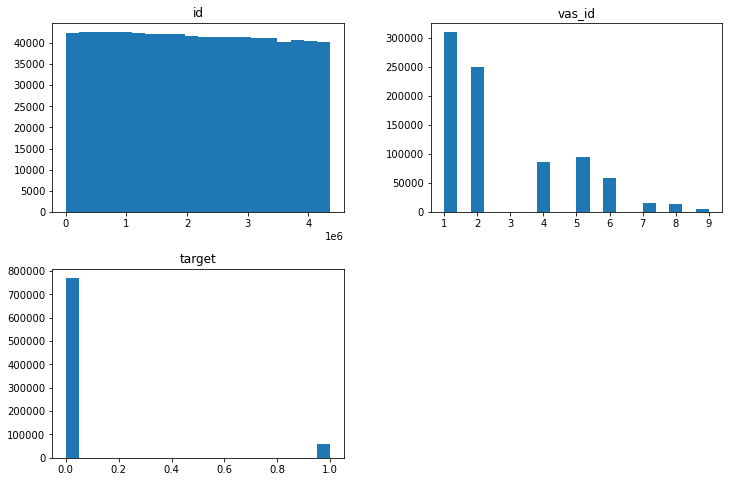

In [22]:
df_train.hist(figsize=(12,8), bins=20, grid=False);

In [23]:
df_train['vas_id'].value_counts()

1.0    310175
2.0    249505
5.0     94085
4.0     85756
6.0     57878
7.0     15432
8.0     13350
9.0      5472
Name: vas_id, dtype: int64

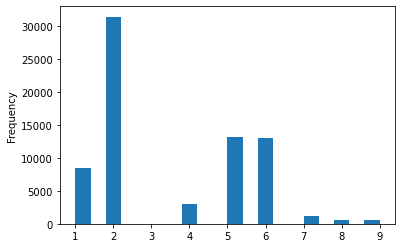

In [24]:
df_test['vas_id'].plot(kind='hist',bins=20);

In [25]:
df_test['vas_id'].value_counts()

2.0    31361
5.0    13073
6.0    12976
1.0     8413
4.0     3058
7.0     1192
8.0      619
9.0      539
Name: vas_id, dtype: int64

#### Услуга под цифрой 3 отсутствует.

In [26]:
df_train['buy_time'].min(),df_train['buy_time'].max()

(datetime.date(2018, 7, 9), datetime.date(2018, 12, 30))

In [27]:
df_test['buy_time'].min(),df_test['buy_time'].max()

(datetime.date(2019, 1, 6), datetime.date(2019, 1, 20))

**train: 09.07.2018 - 31.12.2018**

**test: 7.01.2019 - 21.01.2019**

In [28]:
print('Кол-во уникальных:', df_train['id'].nunique(), 'Мин:', np.min(df_train['id']), 'Макс:', np.max(df_train['id']))

Кол-во уникальных: 806613 Мин: 2 Макс: 4362694


In [29]:
print('Кол-во уникальных:', df_test['id'].nunique(), 'Мин:', np.min(df_test['id']), 'Макс:', np.max(df_test['id']))

Кол-во уникальных: 70152 Мин: 55 Макс: 4362720


### Поиск дубликатов id

In [30]:
df_train.duplicated(subset=['id']).value_counts()

False    806613
True      25040
dtype: int64

In [31]:
df_test.duplicated(subset=['id']).value_counts()

False    70152
True      1079
dtype: int64

In [32]:
df_short.duplicated(subset=['id']).value_counts()

False    872577
True      29812
dtype: int64

In [33]:
ids = df_train["id"]
df_train[ids.isin(ids[ids.duplicated()])].sort_values('id')

,id,vas_id,buy_time,target
14042,342,2.0,2018-11-18,1.0
14041,342,1.0,2018-11-04,0.0
19825,492,6.0,2018-12-16,1.0
19824,492,4.0,2018-10-08,0.0
22908,579,4.0,2018-11-18,1.0
...,...,...,...,...
751154,4339012,2.0,2018-11-18,1.0
248700,4347691,4.0,2018-11-25,0.0
248701,4347691,6.0,2018-11-18,1.0
366175,4350615,2.0,2018-12-09,1.0


In [34]:
print("ID уникален? ", df_train['id'].is_unique)
print("Есть ли дубли в строках?", df_train['id'].duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((df_train['id'].isnull().sum() > 0).sum()/len(df_train['id'])*100))


ID уникален?  False
Есть ли дубли в строках? 25040
Сколько процент признаков могут принимать null-значениями? 0%


In [35]:
df_short['id'].value_counts().sort_values(ascending=False)

3549398    2
3353035    2
2926704    2
3221567    2
1253215    2
          ..
2777413    1
2781432    1
2785623    1
2599316    1
3521152    1
Name: id, Length: 872577, dtype: int64

## Объединение merge_asof nearest

In [36]:
df_train_merge = pd.merge_asof(df_train.sort_values(by=['id']), 
                       df_short.sort_values(by=['id']), 
                       on='id', 
                       by='buy_time', 
                       direction='nearest')

In [37]:
df_test_merge = pd.merge_asof(df_test.sort_values(by=['id']), 
                       df_short.sort_values(by=['id']), 
                       on='id', 
                       by='buy_time', 
                       direction='nearest')

In [38]:
def buy_time(df):
    df_features = df.copy()
    df_features['buy_time'] = \
            (pd.to_datetime(df_features['buy_time']) - pd.Timestamp('1970-01-01')) \
             // pd.Timedelta('1s')
    return df_features

In [39]:
df_train_merge=buy_time(df_train_merge)
df_train_merge

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,2,2.0,1545523200,0.0,-96.799971,229.530888,-110.740786,305.723202,-116.158246,284.61821,...,2300.626154,1492.229208,-21.996269,-35.630448,368.252276,11.167111,7.305572,-12.175933,-0.45614,0.0
1,4,1.0,1533513600,0.0,-42.559971,99.460888,-43.780786,72.293202,-49.198246,51.18821,...,-927.373846,-570.770792,-24.996269,-36.630448,-212.747724,-14.832889,-0.694428,-1.175933,-0.45614,1.0
2,15,1.0,1534118400,0.0,-96.799971,-336.159112,-110.740786,-329.456798,-116.158246,-350.56179,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,16,2.0,1540684800,0.0,155.310029,-92.509112,158.309214,-95.126798,152.891754,-116.23179,...,-977.373846,-613.770792,-25.996269,-37.630448,-291.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4,29,1.0,1533513600,0.0,-42.559971,99.460888,-43.780786,72.293202,-49.198246,51.18821,...,-927.373846,-570.770792,-24.996269,-36.630448,-212.747724,-14.832889,-0.694428,-1.175933,-0.45614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831648,4362634,1.0,1546128000,0.0,-93.749971,-66.149112,-105.190786,-107.776798,-110.608246,-128.88179,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
831649,4362640,2.0,1546128000,0.0,-93.749971,-66.149112,-105.190786,-107.776798,-110.608246,-128.88179,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
831650,4362647,6.0,1546128000,0.0,-93.749971,-66.149112,-105.190786,-107.776798,-110.608246,-128.88179,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
831651,4362684,5.0,1545523200,0.0,-34.169971,43.280888,-36.250786,15.233202,-41.668246,-5.87179,...,-365.373846,-29.770792,-23.996269,-37.630448,2719.252276,-20.832889,-0.694428,-12.175933,-0.45614,0.0


In [40]:
df_test_merge=buy_time(df_test_merge)
df_test_merge

,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,55,2.0,1547337600,-65.299971,71.210888,-75.070786,35.273202,-80.488246,14.16821,-16.08618,...,-551.373846,-209.770792,-24.996269,-37.630448,-133.747724,-20.832889,-0.694428,-12.175933,-0.45614,1.0
1,64,4.0,1547942400,152.050029,257.220888,195.609214,267.113202,190.191754,246.00821,-16.08618,...,3185.626154,-613.770792,-21.996269,-37.630448,-139.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
2,151,2.0,1547337600,-65.299971,71.210888,-75.070786,35.273202,-80.488246,14.16821,-16.08618,...,-551.373846,-209.770792,-24.996269,-37.630448,-133.747724,-20.832889,-0.694428,-12.175933,-0.45614,1.0
3,274,4.0,1547942400,152.050029,257.220888,195.609214,267.113202,190.191754,246.00821,-16.08618,...,3185.626154,-613.770792,-21.996269,-37.630448,-139.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
4,274,2.0,1547337600,-65.299971,71.210888,-75.070786,35.273202,-80.488246,14.16821,-16.08618,...,-551.373846,-209.770792,-24.996269,-37.630448,-133.747724,-20.832889,-0.694428,-12.175933,-0.45614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71226,4362676,2.0,1547942400,-96.799971,177.650888,-110.740786,140.043202,-116.158246,118.93821,-16.08618,...,-968.373846,-611.770792,-11.996269,-31.630448,-162.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
71227,4362677,2.0,1547337600,18.620029,-84.169112,18.159214,-82.216798,12.741754,-103.32179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
71228,4362697,5.0,1546732800,-56.299971,-54.149112,-66.070786,-102.586798,-71.488246,-123.69179,-16.08618,...,-887.373846,-607.770792,-25.996269,-35.630448,-239.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
71229,4362712,5.0,1547337600,18.620029,-84.169112,18.159214,-82.216798,12.741754,-103.32179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


### Сохраним

In [41]:
# df_test_merge.to_csv(TEST_MERGE, index=False, encoding='utf-8')
# df_train_merge.to_csv(TRAIN_MERGE, index=False, encoding='utf-8')

In [42]:
df_train_merge = pd.read_csv(TRAIN_MERGE, encoding='utf-8')

## Split into train and test

In [43]:
X = df_train_merge.drop(['target'], axis=1)
y = df_train_merge['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

0.0    0.92763
1.0    0.07237
Name: target, dtype: float64

In [44]:
FEATURE_NAMES = X.columns.to_list()

### Масштабрование данных<a class="anchor" id="scaler"></a>

In [45]:
#Удалим ненужные файлы
del df_train
del df_test
del df_train_merge
del df_pass
del df_short
del df_test_merge
gc.collect()  

18882

In [46]:
scaler = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train[FEATURE_NAMES] = scaler.fit_transform(X_train_norm)
X_test[FEATURE_NAMES] = scaler.transform(X_test_norm)

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a> 

In [47]:
# train = pd.concat([X_train, y_train], axis=1)
# test = pd.concat([X_test, y_test], axis=1)

In [48]:
# train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
# test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построим Baseline c балансировкой целевой переменной<a class="anchor" id="target_balancing"></a>

In [49]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [50]:
import inspect
print(inspect.getsource(balance_df_by_target))

def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampli

In [51]:
def init_models():
    model_lr = LogisticRegression(random_state=21,n_jobs=-1)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_xgb = xgb.XGBClassifier(random_state=21,n_jobs=-1)
    model_lgbm = lgbm.LGBMClassifier(random_state=21,n_jobs=-1)
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    models = {
        'lr': model_lr,
#         'knn': model_knn,
#         'tree': model_tree,
#         'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [52]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0.0']['f1-score']
    f1_1 = report['1.0']['f1-score']
    return f1_macro, f1_0, f1_1

In [53]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

**Ничего не делаем с данными**

In [54]:
# %%time
# stata_not_balanced, models_not_balanced = run_experiment(X_train, X_test, y_train, y_test, method='not')
# stata_not_balanced

**Oversampling**

In [55]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, 'target', method='over')
    
# df_balanced['target'].value_counts()

In [56]:
# X_train_balanced = df_balanced.drop(columns='target')
# y_train_balanced = df_balanced['target']

In [57]:
# %%time
# stata_balanced_over, models_over = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='over')
# stata_balanced_over

**Undersampling**

In [58]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, 'target', method='under')
    
# df_balanced['target'].value_counts()

In [59]:
# X_train_balanced = df_balanced.drop(columns='target')
# y_train_balanced = df_balanced['target']

In [60]:
# %%time
# stata_balanced_under, models_under = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='under')
# stata_balanced_under

**Oversampling (SMOTE)**

In [61]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE()
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# y_train_balanced.value_counts()

In [62]:
# %%time
# stata_balanced_smote, models_smote = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='smote')
# stata_balanced_smote

**Сводим результаты вместе**

In [63]:
# stata_combined = stata_not_balanced.merge(stata_balanced_over, on='model_name') \
#     #.merge(stata_balanced_under, on='model_name') \
# #                                    .merge(stata_balanced_smote, on='model_name')
                                  
                                  
# stata_combined.head()

In [64]:
# stata_combined.sort_values('f1_1_test_over', ascending=False).iloc[0]

In [65]:
# model = models_over['cat']

In [66]:
# pred_train = model.predict(X_train_balanced)
# pred_test = model.predict(X_test)

# evaluate_preds(model, X_train_balanced, X_test, y_train_balanced, y_test)

**Код закоментировал для удобства. По сводной таблице лучшие результаты Catboost и Over**

In [67]:
TARGET_NAME = 'target'

In [68]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0.0    540027
1.0    505560
Name: target, dtype: int64

In [69]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [70]:
frozen_params = {
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

### Модель, полученная с нормализованными признаками<a class="anchor" id="model_from_prev_lesson"></a>

In [71]:
%%time

model_catb_norm = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=7)
model_catb_norm.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb_norm, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    540027
         1.0       0.71      0.31      0.44     42130

    accuracy                           0.94    582157
   macro avg       0.83      0.65      0.70    582157
weighted avg       0.93      0.94      0.93    582157

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    231440
         1.0       0.66      0.29      0.40     18056

    accuracy                           0.94    249496
   macro avg       0.80      0.64      0.68    249496
weighted avg       0.93      0.94      0.93    249496

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     228797  2643
1.0      12865  5191
CPU times: user 2min 57s, sys: 3.18 s, total: 3min
Wall time: 27.1 s


### Модель, полученная с OVER<a class="anchor" id="model_from_prev_lesson"></a>

In [72]:
%%time

model_catb_over = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=7)
model_catb_over.fit(X_train_balanced, y_train_balanced, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb_over, X_train_balanced, X_test, y_train_balanced, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.90    540027
         1.0       0.87      0.92      0.90    505560

    accuracy                           0.90   1045587
   macro avg       0.90      0.90      0.90   1045587
weighted avg       0.90      0.90      0.90   1045587

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    231440
         1.0       0.35      0.89      0.51     18056

    accuracy                           0.87    249496
   macro avg       0.67      0.88      0.72    249496
weighted avg       0.94      0.87      0.90    249496

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     201980  29460
1.0       1941  16115
CPU times: user 9min 33s, sys: 2.79 s, total: 9min 36s
Wall time: 1min 18s


### Модель, полученная с гиперпораметром штраф за веса<a class="anchor" id="model_from_prev_lesson"></a>

In [73]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

12.818110610016616

In [74]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [75]:
%%time

model_catb_weights = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=7)
model_catb_weights.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb_weights, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92    540027
         1.0       0.35      0.91      0.50     42130

    accuracy                           0.87    582157
   macro avg       0.67      0.89      0.71    582157
weighted avg       0.95      0.87      0.89    582157

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92    231440
         1.0       0.35      0.91      0.50     18056

    accuracy                           0.87    249496
   macro avg       0.67      0.89      0.71    249496
weighted avg       0.95      0.87      0.89    249496

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     200443  30997
1.0       1645  16411
CPU times: user 1min 2s, sys: 473 ms, total: 1min 3s
Wall time: 9.9 s


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [76]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(model_catb_weights, file)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

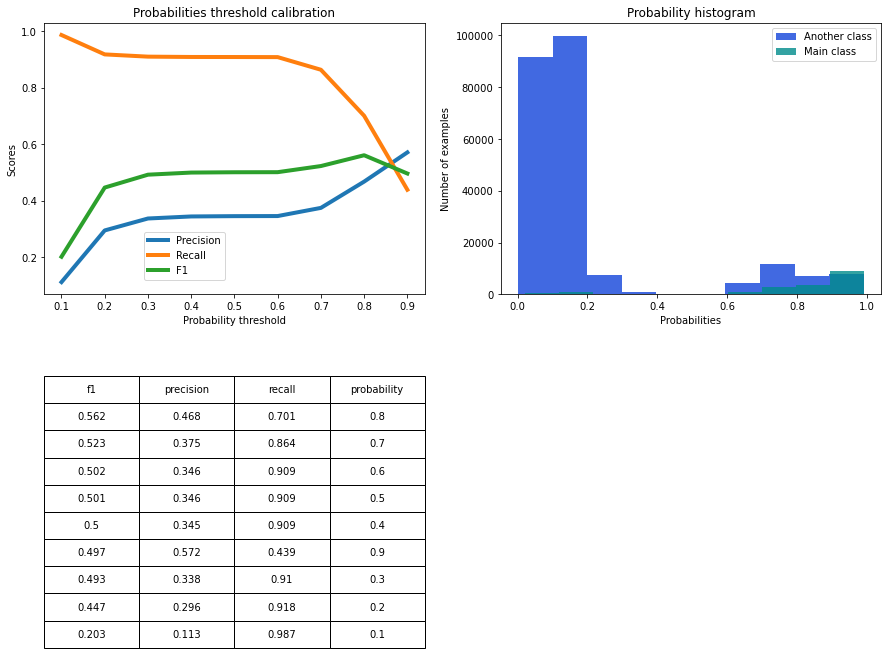

In [77]:
preds = model_catb_weights.predict_proba(X_test)
show_proba_calibration_plots(preds[:, 1], y_test)

In [78]:
preds

array([[0.97064229, 0.02935771],
       [0.83692265, 0.16307735],
       [0.88988172, 0.11011828],
       ...,
       [0.8380149 , 0.1619851 ],
       [0.91699385, 0.08300615],
       [0.98020399, 0.01979601]])

In [79]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [80]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score, classification_report,
                             precision_recall_curve, confusion_matrix)

In [81]:
precision, recall, thresholds = precision_recall_curve(y_test, preds[:, 1])

In [82]:
thresholds

array([0.02079386, 0.02079471, 0.02079496, ..., 0.99084196, 0.99095167,
       0.9915972 ])

**Выберем лучшую отсечку**

In [83]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.2f}, F-Score={fscore[ix]:.3f}',
      f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.80, F-Score=0.562 Precision=0.467, Recall=0.704


In [84]:
thresholds[ix]

0.7986988781481589

In [85]:
print(classification_report(y_test, preds[:, 1] >= thresholds[ix]))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96    231440
         1.0       0.47      0.70      0.56     18056

    accuracy                           0.92    249496
   macro avg       0.72      0.82      0.76    249496
weighted avg       0.94      0.92      0.93    249496



### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [86]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(model_catb_weights, file)

### Формирование индивидуальных предсказаний абонентам

In [87]:
test = pd.read_csv(TEST_MERGE)

In [88]:
offer = pd.DataFrame(test)
model_catb_weights.predict_proba(test)[:,1]

array([0.02316182, 0.06143541, 0.02316182, ..., 0.06968416, 0.06019391,
       0.03271236])

In [89]:
# создаём датафрейм с айлишниками абонентов
offer_predict = pd.DataFrame(test['id'].copy())

# проходим цилом по номерам подключаемых услуг
for i in [1, 2, 4, 5, 6, 7, 8, 9]:
    # создаём датафрейм с услугой
    offer = pd.DataFrame(test)
    offer['vas_id'] = i
    # предиктим вероятность подключения услуги
    offer_predict[i] = model_catb_weights.predict_proba(offer)[:,1]
offer_predict['max prob offer'] = offer_predict.iloc[:, 1:-1].max(axis = 1)
offer_predict['vas_id offer'] = offer_predict.iloc[:, 1:-1].idxmax(axis = 1)
offer_predict


,id,1,2,4,5,6,7,8,9,max prob offer,vas_id offer
0,55,0.012288,0.023162,0.135736,0.135736,0.135736,0.135736,0.135736,0.135736,0.135736,4
1,64,0.010974,0.027049,0.061435,0.061435,0.061435,0.061435,0.061435,0.061435,0.061435,4
2,151,0.012288,0.023162,0.135736,0.135736,0.135736,0.135736,0.135736,0.135736,0.135736,4
3,274,0.010974,0.027049,0.061435,0.061435,0.061435,0.061435,0.061435,0.061435,0.061435,4
4,274,0.012288,0.023162,0.135736,0.135736,0.135736,0.135736,0.135736,0.135736,0.135736,4
...,...,...,...,...,...,...,...,...,...,...,...
71226,4362676,0.011236,0.026987,0.142023,0.142023,0.142023,0.142023,0.142023,0.142023,0.142023,4
71227,4362677,0.018060,0.030617,0.060194,0.060194,0.060194,0.060194,0.060194,0.060194,0.060194,4
71228,4362697,0.018337,0.032712,0.069684,0.069684,0.069684,0.069684,0.069684,0.069684,0.069684,4
71229,4362712,0.018060,0.030617,0.060194,0.060194,0.060194,0.060194,0.060194,0.060194,0.060194,4


### Посмотрим распределение услуг, рекомендуемых к подключению

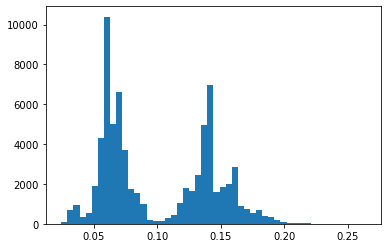

In [90]:
plt.hist(offer_predict['max prob offer'], bins=50);

#### Выбираем порог взависимости от предоставленных ресурсов